# Problem set 3 (90 pts)

## Important note: the template for your solution filename is Name_Surname_PS3.ipynb

## Problem 1 (25 pts)

- (5 pts) Prove that $\mathrm{vec}(AXB) = (B^\top \otimes A)\, \mathrm{vec}(X)$ if $\mathrm{vec}(X)$ is a columnwise reshape of a matrix into a long vector. What does it change if the reshape is rowwise? 

**Note:** To make a columnwise reshape in Python one should use ```np.reshape(X, order='f')```, where the string ```'f'``` stands for the Fortran ordering. 

- (2 pts) What is the complexity of a naive computation of $(A \otimes B) x$? Show how it can be reduced.

- (3 pts) Let matrices $A$ and $B$ have eigendecompositions $A = S_A\Lambda_A S_A^{-1}$ and $B = S_B\Lambda_B S^{-1}_B$. Find eigenvectors and eigenvalues of the matrix $A\otimes I + I \otimes B$, where dimension of $I$ coincides with the dimension of $A$ and $B$.


- (10 pts) Let $A = \mathrm{diag}\left(\frac{1}{1000},\frac{2}{1000},\dots \frac{999}{1000}, 1, 1000 \right)$. Estimate analytically the number of iterations required  to solve linear system with $A$ with the relative accuracy $10^{-4}$ using
    - Richardson iteration with the optimal choice of parameter (use $2$-norm)
    - Chebyshev iteration (use $2$-norm)
    - Conjugate gradient method (use $A$-norm).
    
- (5 pts) Provide numerical confirmation of your estimate from theoretical point of view

### a)

In [ ]:
import numpy as np

n = np.random.randint(low=5, high=100)
A = np.random.rand(n, n)
B = np.random.rand(n, n)
X = np.random.rand(n, n)

In [ ]:
vecX = np.reshape(X, n ** 2, order="f")
vecAXB = np.reshape(A @ X @ B, n ** 2, order="f")

Now compare the norms of left and right part of the equation:

In [ ]:
print(f"For n = {n} the absolute error is:")
np.linalg.norm(vecAXB) - np.linalg.norm(np.kron(B.T, A) @ vecX)

For n = 50 the absolute error is:


-1.8189894035458565e-12

In case we are reshaping the vector rowwise, we need to swap the operands in the Kroneker product: 

$\mathrm{row}(AXB) = (A \otimes B^\top)\, \mathrm{row}(X)$ if $\mathrm{row}(X)$ is a rowwise reshape of $X$

In [ ]:
vecX = np.reshape(X, n ** 2)
vecAXB = np.reshape(A @ X @ B, n ** 2)

In [ ]:
print(f"For n = {n} the absolute error is:")
np.linalg.norm(vecAXB) - np.linalg.norm(np.kron(A, B.T) @ vecX)

For n = 50 the absolute error is:


0.0

### b)

Assume $A$ is $n \times m$, $B$ is $l \times k$, and $x$ is $mk$.

For each block we need $l \times k$ multiplications, and we need to repeat on $n \times m$ blocks, therefore the computation complexity is $n\times m\times l\times k$ multiplications. 

We need to add the complexity of $m^2 k^2$ multiplications, since we multiply by vector $x$. The result is $mk(mk + nl)$ multiplications.

To reduce that, let's try to use this strategy:

1. Make a block vector of size $mk$, which repeats the matrix $B$. This is a matrix $\Gamma$ of size $l \times mk$.
2. Multiply $x$ by every row of $\Gamma$ elementwise. This results in $lmk$ multiplications. The result matrix is $\Gamma'$.
3. Now repeatedly append $\Gamma'$ to itself columnwise $n$ times.
4. Now, multiply every block of this matrix by index-corresponding element of $A$, which is $nmlk$ multiplications.
5. Sum all the rows.

Therefore, overall we have $(n+1)mlk$ multiplications.


### c)

This expression appears to be Kronecker sum: $A \oplus B = A\otimes I + I \otimes B$.

Kronecker sum [has this property](https://math.stackexchange.com/questions/3600849/the-eigenvalues-of-a-specific-kronecker-sum#:~:text=The%20Kronecker%20sum%20has%20the,%3D1%2C%E2%80%A6%2Cm), that its eigenvalues are pairwaise sums of spectrums of $A$ and $B$.

Let also size of $A$ is $n \times n$, size of $B$ is $m \times m$.

Therefore (assuming $\Lambda_{A \oplus B}, \Lambda_{B}, \Lambda_{A}$ are 1D vectors and $\Lambda_{A \oplus B}$ is in arbitary order):

$\Lambda_{A \oplus B} = \lambda_{Ai} + \lambda_{Bj}$ for $i = 1, ..., n$; $j = 1,...,m$

For eigenvectors:

$S_{A \oplus B} = [s_{Ai} \otimes s_{Bj}]$ for $i = 1, ..., n$; $j = 1,...,m$

### d)

Since those numbers will surely depend on initial guess $x_0$ and true value of $x$, let's generate them before the calculations:

In [ ]:
import numpy as np

a = []
for i in range(1, 1000):
    a.append(i/1000)

a.extend([1, 1000])

A = np.zeros((1001, 1001))
np.fill_diagonal(A, a)

x0 = np.zeros(1001)
f = np.random.rand(1001)
x_true = np.linalg.solve(A , f)

**Richardson.**

So we need found optimal $\tau$.

Let $k$ be the number of iterations and $q = \frac{cond(A) - 1}{cond(A) + 1} = \frac{10^6 - 1}{10^6 + 1} = 0.999998$. We need to satisfy:

### $\frac{||e_0||_2}{||x_{true}||_2} q^k \geq \frac{||e_k||_2}{||x_{true}||_2}$


The right part is relative error. Therefore we can substitute $10^{-4}$:

### $q^k \geq \frac{||x_{true}||_2 }{||e_0||_2} 10^{-4}$

Also in every algorithm we input initial assumption $x_0$ therefore $||e_0||_2 = ||x_0 - x_{true}||_2$

### $k \lg q \geq -4 + \lg||x_{true}||_2 - \lg||e_0||_2$

### $k \geq \frac{-4 + \lg||x_{true}||_2 - \lg||x_0 - x_{true}||_2}{\lg q}$

In [ ]:
x_true_norm = np.linalg.norm(x_true)
diff_norm = np.linalg.norm(x0 - x_true)

q = (10 ** 6 -1)/(10 ** 6 + 1)

In [ ]:
k = np.ceil((-4 + np.log10(x_true_norm) - np.log10(diff_norm)/np.log10(q)))

Co the theoretical result for the number iterations is: 

In [ ]:
k

3195271.0

That is a lot.

Let's provide the numerical proof!

In [ ]:
def richardson_iteration(A, f, x0, error_threshold):
    x_true = np.linalg.solve(A, f)
    eigvals = np.linalg.eigvals(A)
    t_opt = 2 / (np.max(eigvals) + np.min(eigvals))
    x = x0
    errors = []
    i = 0
    while True:
      x = x - t_opt * (A @ x - f)
      error = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
      if error <= error_threshold:
          break
      errors.append(error)
      if i % 1000 == 0:
        print(error)
    return x, errors

In [ ]:
rich_result, rich_errors = richardson_iteration(A, f, x0, 10e-4)

The practical result for iterations is:

In [ ]:
len(rich_errors)

3064241

**Chebyshev.**



Here, $q = \frac{\sqrt{cond(A)} - 1}{\sqrt{cond(A)} + 1} = \frac{10^3 - 1}{10^3 + 1} = 0.998$

### $q^k \geq \frac{||x_{true}||_2 }{||e_0||_2 C} 10^{-4}$

### $k \geq \frac{-4 + \lg||x_{true}||_2 - \lg||x_0 - x_{true}||_2}{\lg q} - 1.002 C$


In [ ]:
q = (10 ** 3 - 1)/(10 ** 3 + 1)

In [ ]:
k = np.ceil((-4 + np.log10(x_true_norm) - np.log10(diff_norm)/np.log10(q)))

The theoretical result for Chebyshev iterations is (minus constant):

In [ ]:
k

3195.0

So now let's implement it (code from [here](https://en.wikipedia.org/wiki/Chebyshev_iteration))

In [ ]:
def chebyshev_iteration(A, f, x0, error_threshold):
    x_true = np.linalg.solve(A, f)
    x_true_norm = np.linalg.norm(x_true)
    eigvalues = np.linalg.eigvals(A)
    lam_max, lam_min = np.max(eigvalues), np.min(eigvalues)
    d = (lam_max + lam_min)/2
    c = (lam_max - lam_min)/2
    pre_cond = np.eye(A.shape[0])
    x = x0
    r = f - A @ x

    i = 0
    errors = []

    while True:
        z = np.linalg.solve(pre_cond, r)
        if i == 0:
            p = z
            alpha = 1/d
        elif i == 1:
            beta = (1/2) * (c * alpha) ** 2
            alpha = 1/(d - beta/alpha)
            p = z + beta * p 
        else:
            beta = (c * alpha/2) ** 2
            alpha = 1/(d - beta / alpha)
            p = z + beta * p
        
        x = x + alpha * p
        r = f - A @ x
        error = np.linalg.norm(x_true - x)/x_true_norm
        errors.append(error)
        if error <= error_threshold:
            break
        if i % 500:
            print(error)    
        i += 1
    return x, errors

In [ ]:
cheb_result, cheb_errors = chebyshev_iteration(A, f, x0, 1e-4)

The practical result for iterations is:

In [ ]:
len(cheb_errors)

4835

**Conjugate gradient**

$q \times 2 \geq 10^{-4}$

$q^k \geq \frac{1}{10^4 \times 2}$

$k \geq - \log_q 2 - \log_q 4$



$k \geq 172$

In [ ]:
import math

- math.log(2, 0.988) - math.log(4, 0.988)

172.24498235531684

In [ ]:
def conjgrad(A, b, x, error_threshold):
    r = b - np.dot(A, x)
    p = r
    rsold = np.dot(np.transpose(r), r)
    i = 0
    errors = []
    while True:
        Ap = np.dot(A, p)
        alpha = rsold / np.dot(np.transpose(p), Ap)
        x = x + np.dot(alpha, p)
        r = r - np.dot(alpha, Ap)
        rsnew = np.dot(np.transpose(r), r)
        error = np.sqrt(rsnew)
        errors.append(error)
        if error < error_threshold:
            break
        p = r + (rsnew/rsold)*p
        rsold = rsnew
        i += 
    return x, errors

In [ ]:
conj_result, conj_errors = conjgrad(A, f, x0, 1e-4)

In [ ]:
np.linalg.norm(A @ conj_result - f)

9.637054453693894e-05

In [ ]:
len(conj_errors)

168

This is quite close.


## Problem 2 (40 pts)

### Spectral graph partitioning and inverse iteration


Given connected graph $G$ and its corresponding graph Laplacian matrix $L = D - A$ with eigenvalues $0=\lambda_1, \lambda_2, ..., \lambda_n$, where $D$ is its degree matrix and $A$ is its adjacency matrix, *Fiedler vector* is an eignevector correspondng to the second smallest eigenvalue $\lambda_2$ of $L$. Fiedler vector can be used for graph partitioning: positive values correspond to the one part of a graph and negative values to another.

### Inverse power method (15 pts)

To find the Fiedler vector we will use the inverse iteration with adaptive shifts (Rayleigh quotient iteration). 

* (5 pts) Write down the orthoprojection matrix on the space orthogonal to the eigenvector of $L$, corresponding to the eigenvalue $0$ and prove (analytically) that it is indeed an orthoprojection.
 
* (5 pts) Implement the spectral partitioning as the function ```partition```:

### a)

To find the egenvector corresponding to $\lambda = 0$, we need to just solve this equation:

$Lx = 0$

The answer is $v_1 = [1, 1, ... 1]^T$, because the sum of all the rows of the Laplacian results in $0$. Now we need to find the subspace which is orthogonal to that vector. 



To project vector $x$ on the plane, the normal vector of which is $\mathcal{n}$, we need to calculate this:

### $p(x) = x - \frac{xn}{||n||_2^2}n \rightarrow P = 1 - \frac{(n, n)}{N} = 1 - \frac{(v_1, v_1)}{N}$

### Let $J = (v_1, v_1)$ be the matrix of ones. Therefore:

### $P = I - \frac{1}{N}J$

To check that $P$ is an orthoprojection, let's check $P^2 = P^{*} = P$.

### 1. $P^* = P^T$ (the matrix is real)
### 2. $P$ is symmetric, since we substitute single-entry matrix out of a symmetric matrix. Therefore $P^T = P$.
### 3. $P^2 = I - \frac{2}{N}J + \frac{1}{N^2}J^2 = I - \frac{2}{N}J + \frac{N}{N^2}J = I - \frac{1}{N}J$ 
(in this line we used the property of matrix of ones: $J^{k} = N^{k-1}J$)

### b)

In [2]:
import numpy as np
from scipy.sparse import issparse, csr_matrix, linalg

In [3]:
# INPUT:
# A - adjacency matrix (scipy.sparse.csr_matrix)
# num_iter_fix - number of iterations with fixed shift (int)
# shift - (float number)
# num_iter_adapt - number of iterations with adaptive shift (int) -- Rayleigh quotient iteration steps
# x0 - initial guess (1D numpy.ndarray)
# OUTPUT:
# x - normalized Fiedler vector (1D numpy.ndarray)
# eigs - eigenvalue estimations at each step (1D numpy.ndarray)
# eps - relative tolerance (float)
def partition(A, shift, num_iter_fix, num_iter_adapt, x0, eps):  
    x = x0
    eigs = []
    n = A.shape[0]
    P = np.eye(n) - 1/n * np.ones((n,n))
    A = P @ A
    i = 0
    j = 0
    
    for i in range(num_iter_fix):
        x = A @ x
        x = x/np.linalg.norm(x)
        
        h2 = np.eye(np.shape(A)[0], np.shape(A)[1])
        h1 = A - shift*h2
        h = np.linalg.inv(h1)@x
        u = np.linalg.norm(h)
        x = h/u
        x = x.T
        
        x1 = A @ x
        
        x2 = x.T@x1
        
        m = x2/(x.T @ x)
        
        if (np.linalg.norm(shift - m)/np.linalg.norm(shift)) <= eps:
             return x, np.array(eigs)
        else:
            i+=1
    
    eigenvalue = ((x.T) @ A @ x)/(x.T @ x)
    eigs.append(eigenvalue)
    
    for j in range(num_iter_adapt):
        h2 = np.eye(np.shape(A)[0], np.shape(A)[1])
        h1 = A - eigs[j]*h2
        h = np.linalg.inv(h1)@x
        u = np.linalg.norm(h)
        x = h / u
             
        x = x.T
        
        eigenvalue = ((x.T) @ A @ x)/(x.T @ x)
        eigs.append(eigenvalue)
        
        if np.linalg.norm(eigs[j] - eigs[j-1])/ np.linalg.norm(eigs[j]) <= eps:
            return x, np.array(eigs)
        else:
            j+=1
        
    return x, np.array(eigs)

Algorithm must halt before `num_iter_fix + num_iter_adapt` iterations if the following condition is satisfied $$ \boxed{\|\lambda_k - \lambda_{k-1}\|_2 / \|\lambda_k\|_2 \leq \varepsilon} \text{ at some step } k.$$

Do not forget to use the orthogonal projection from above in the iterative process to get the correct eigenvector.
It is also a good idea to use ```shift=0``` before the adaptive stragy is used. This, however, is not possible since the matrix $L$ is singular, and sparse decompositions in ```scipy``` does not work in this case. Therefore, we first use a very small shift instead.

* (3 pts) Generate a random `lollipop_graph` using `networkx` library and find its partition. [Draw](https://networkx.github.io/documentation/networkx-1.9/examples/drawing/labels_and_colors.html) this graph with vertices colored according to the partition.

* (2 pts) Start the method with a random initial guess ```x0```, set ```num_iter_fix=0``` and comment why the method can converge to a wrong eigenvalue.

### c)

In [50]:
import networkx as nx

n = np.random.randint(25)
G = nx.lollipop_graph(n, n)

L = nx.linalg.laplacianmatrix.laplacian_matrix(G)

In [51]:
n = L.shape[0]

In [52]:
shift = 1e-4
eps = 1e-4
num_iter_fix = 1000
num_iter_adapt = 1000

x0 = np.random.rand(L.shape[0])

In [53]:
x, eigs = partition(L, shift, num_iter_fix, num_iter_adapt, x0, eps)

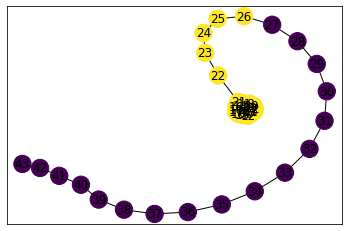

In [54]:
nx.draw_networkx(G, node_color=np.sign(x))

### d)

In [55]:
num_iter_fix = 0
x, eigs = partition(L, shift, num_iter_fix, num_iter_adapt, x0, eps)

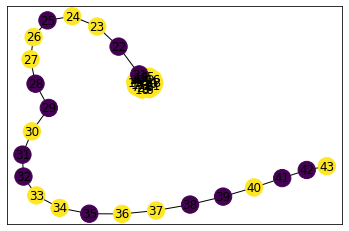

In [56]:
nx.draw_networkx(G, node_color=np.sign(x))

So, as was stated, we need the shift to be rather small. So we install this fixed shift for some number iterations, because we don't know what $R(x_i)$ might be at the first iteration.

In worst case, if the initial guess $Ax_0$ is orthogonal to $x_0$, the $R(x_0)$ becomes $1$, and thus $A$ is shifted by $I$, which is a lot. 

So, we first need to make sure that $x_{i}$ is close enough to be the eigenvector and then start Rayleigh quotient iteration.

### Spectral graph properties (15 pts)

* (5 pts) Prove that multiplicity of the eigenvalue $0$ in the spectrum of the graphs Laplacian is the number of its connected components.
* (10 pts) The second-smallest eigenvalue of $L(G)$, $\lambda_2(L(G))$, is often called the algebraic connectivity of the
graph $G$. A basic intuition behind the use of this term is that a graph with a higher algebraic
connectivity typically has more edges, and can therefore be thought of as being “more connected”.  
To check this statement, create few graphs with equal number of vertices using `networkx`, one of them should be $C_{30}$ - simple cyclic graph, and one of them should be $K_{30}$ - complete graph. (You also can change the number of vertices if it makes sense for your experiments, but do not make it trivially small).
    * Find the algebraic connectivity for the each graph using inverse iteration.
    * Plot the dependency $\lambda_2(G_i)$ on $|E_i|$.
    * Draw a partition for a chosen graph from the generated set.
    * Comment on the results.

### e)

So our graph has $n$ connected components, therefore the adjacency matrix $A$ can be block diagonal with $n$ blocks $\rightarrow$  Laplacian $L$ also has $n$ blocks.

As we found out before, matrix $L$ of a connected graph (with at least 2 vertices) has to always have eigenvalue $\lambda = 0$ (not exactly minimal), because there is always a solution for $Lv = 0$, which is $v_1 = [1, 1, 1, ...1]^T.$

Each of blocks of $L$ represents a seperate componenct of a graph, therefore all of those blocks have eigenvalue $0$.

There is a theorem ([3.9](https://math.uchicago.edu/~may/REU2013/REUPapers/Marsden.pdf)) that every $d$-regular graph's zero eigenvalue has multiplicity equal to exactly to $1$, iff all the vertices have degree $d$ (in other words, they are connected).

So we've got $n$ blocks, each represent a connected componenct of the graph. Multiplicity of every component's zero eigenvalue is $1$.

Determinant of a diagonal block matrix is a product of determinants of all the blocks. Therefore the multiplicity of every block's zero eigenvalue distributes to the whole graph.




### f)



In [57]:
import networkx as nx

C30 = nx.cycle_graph(30)
K30 = nx.complete_graph(30)

In [58]:
L30 = nx.lollipop_graph(15, 15)
Lad30 = nx.ladder_graph(30)

In [59]:
K10 = nx.complete_graph(10)
K20 = nx.complete_graph(20)

In [60]:
while True:
    try:    
        x_c, eigs_c = partition(nx.linalg.laplacianmatrix.laplacian_matrix(C30), 1e-4, 1000, 1000, np.random.rand(30), 1e-4)
        x_k, eigs_k = partition(nx.linalg.laplacianmatrix.laplacian_matrix(K30), 1e-4, 1000, 1000, np.random.rand(30), 1e-4)
        x_k10, eigs_k10 = partition(nx.linalg.laplacianmatrix.laplacian_matrix(K10), 1e-4, 1000, 1000, np.random.rand(10), 1e-4)
        x_k20, eigs_k20 = partition(nx.linalg.laplacianmatrix.laplacian_matrix(K20), 1e-4, 1000, 1000, np.random.rand(20), 1e-4)
        x_l, eigs_l = partition(nx.linalg.laplacianmatrix.laplacian_matrix(L30), 1e-4, 1000, 1000, np.random.rand(30), 1e-4)
        x_lad, eigs_lad = partition(nx.linalg.laplacianmatrix.laplacian_matrix(Lad30), 1e-4, 1000, 1000, np.random.rand(60), 1e-4)
    except: # singular matrices sometimes generate
        continue
    break

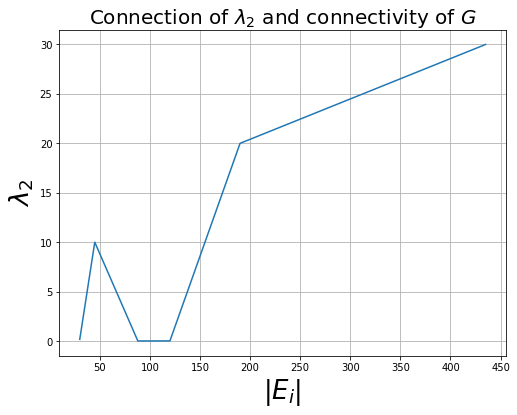

In [61]:
import matplotlib.pyplot as plt

edges = [C30.number_of_edges(), Lad30.number_of_edges(), L30.number_of_edges(), K10.number_of_edges(), K20.number_of_edges(), K30.number_of_edges()]
eigvals = [eigs_c[-1], eigs_lad[-1], eigs_l[-1], eigs_k10[-1], eigs_k20[-1], eigs_k[-1]]

lists = sorted(zip(*[edges, eigvals]))
new_edges, new_eigvals = list(zip(*lists))

plt.figure(figsize=(8,6))
plt.plot(new_edges,new_eigvals);
plt.ylabel("$\lambda_2$", fontsize=26)
plt.xlabel("$|E_i|$", fontsize=26)
plt.title("Connection of $\lambda_2$ and connectivity of $G$", fontsize=20)
plt.grid()

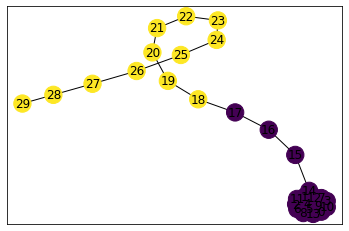

In [62]:
nx.draw_networkx(L30, node_color=np.sign(x_l))

The intuition works. The most connected graph is $K_{30}$ and it indeed has the largest $\lambda_2$.  

### Image bipartition (10 pts)

Let us deal here with a graph constructed from a binarized image.
Consider the rule, that graph vertices are only pixels with $1$, and each vertex can have no more than $8$ connected vertices (pixel neighbours), $\textit{i.e}$ graph degree is limited by 8.
* (3 pts) Find an image with minimal size equal to $(256, 256)$ and binarize it such that graph built on black pixels has exactly $1$ connected component.
* (5 pts) Write a function that constructs sparse adjacency matrix from the binarized image, taking into account the rule from above.
* (2 pts) Find the partition of the resulting graph and draw the image in accordance with partition.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


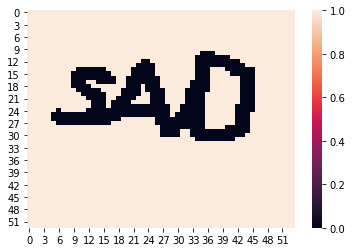

In [5]:
import numpy as np
from PIL import Image
import networkx as nx
import seaborn as sns

img_path = "drive/MyDrive/Colab Notebooks/2.png"

im = Image.open(img_path)
im = im.convert("1")
im = np.array(im, dtype="int")

sns.heatmap(im);

In [6]:
im = np.array(im, dtype="int")

I don't quite get why we need adjacency matrix for this, so I'll create a fucntion that generates a graph from the image:

In [7]:
def graph_from_binary_image(im):
    G = nx.Graph()
    G.add_nodes_from(range(im.shape[0] * im.shape[1] - np.sum(im)))
    k = 0
    for i in range(1, im.shape[0] - 1):
        for j in range(1, im.shape[1] - 1):
            if im[i][j] == 1:
                im[i][j] = 0
                continue 
            im[i][j] = k
            k += 1
            neighbours = [im[i-1][j-1], im[i][j-1], im[i-1][j], im[i-1][j+1]]
            for n in neighbours:
                if n != 0:
                    G.add_edge(im[i][j], n)
    return G 

In [8]:
G = graph_from_binary_image(im)
L = nx.linalg.laplacianmatrix.laplacian_matrix(G)

L

<399x399 sparse matrix of type '<class 'numpy.longlong'>'
	with 2906 stored elements in Compressed Sparse Row format>

In [9]:
x, eigs = partition(L, 1e-4, 1000, 1000, np.ones(L.shape[0]), 1e-4)

Apply the partition to our image:

In [10]:
k = 0
for i in range(1, im.shape[0] - 1):
    for j in range(1, im.shape[1] - 1):
        if im[i][j] != 0:
            im[i][j] = np.sign(x[k]) * 5000
            k += 1

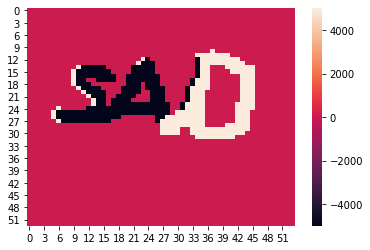

In [11]:
sns.heatmap(im);

## Problem 3 (25 pts)

**Disclaimer**: this problem is released first time, so some typos can be found. 

## Mathematical model (Navier-Stokes equations)

The governing equations for two-dimensional incompressible
flows can be written in a dimensionless form as:

\begin{equation}\tag{1}
\dfrac{\partial \omega}{\partial t} = \dfrac{1}{Re} \big(\dfrac{\partial^2 \omega}{\partial x^2} + \dfrac{\partial^2 \omega}{\partial y^2}\big) - \big(\dfrac{\partial \psi}{\partial y} \dfrac{\partial \omega}{\partial x} - \dfrac{\partial \psi}{\partial x} \dfrac{\partial \omega}{\partial y}\big),
\end{equation}

along with the kinematic relationship between vorticity $\omega(x,y,t)$ and stream function $\psi(x,y,t)$ according to the Poisson equation, which is given as:

\begin{equation}\tag{2}
\dfrac{\partial^2 \psi}{\partial x^2} + \dfrac{\partial^2 \psi}{\partial y^2} = -\omega.
\end{equation}

We consider equations (1) and (2) in the computational domain $\Omega = [0, 2\pi] \times [0, 2\pi]$ and impose the following periodic boundary conditions:

$$\omega(x,0,t) =\omega(x, 2\pi, t), \quad \omega(0,y,t) =\omega(2\pi, y, t), \quad t \geq 0,$$
and the same for $\psi(x,y,t)$.

Note: the Reynolds number, referred to as $Re$, is a fundamental physical constant that in particular determines whether the fluid flow is laminar or turbulent.

## The animation below represents a particular solution of the Navier-Stokes equations (1) and (2) and you will get it in the end of this problem
<img src="vorticity_N1024_Re10000.0_tau0.001.gif" />

# Fourier-Galerkin pseudospectral method

Fourier series expansion based methods are often used for solving problems with periodic boundary conditions. One of the most accurate methods for solving the Navier–Stokes equations in periodic domains is **the pseudospectral method**, which exploits the Fast Fourier Transform (FFT) algorithm. 

Outline: the main idea of spectral methods is to write the solution of a differential equation as a sum of certain "basis functions" (e.g. Fourier series, Chebyshev polynomials etc) and then to choose the coefficients in the sum in order to satisfy the differential equation as well as possible.

Comprehensive survey of such methods can be found in [this book](https://depts.washington.edu/ph506/Boyd.pdf).

### Discrete Fourier Transform

We discretize the domain $[0,L_x]\times[0, L_y]$ by introducing a computation **grid** consisting of $N_x \times N_y$ equally spaced points.

The discrete grid coordinates for $i = 0, 1, \ldots, N_x$ and $j = 0, 1, \ldots, N_y$ are given by:

$$x_i = \frac{i L_x}{N_x}, \quad y_j = \frac{j L_y}{N_y}.$$

Note, that since the domain is periodic $x_0 = x_{N_x}$ and $y_0 = y_{N_y}$.

 Then, any discrete function $u_{i,j} = u(x_i,y_j)$ can be transformed to the Fourier space using the Discrete Fourier Transform (DFT):

$$ \tilde{u}_{m,n} = \sum_{i = 0}^{N_x - 1}\sum_{j = 0}^{N_y - 1} u_{i, j}e^{-
\mathbf{i}(\frac{2\pi m}{L_x}x_i + \frac{2\pi n}{L_y}y_j)},$$

and its inverse transform is:

$$ u_{i,j} = \frac{1}{N_x N_y} \sum_{m = -\frac{N_x}{2}}^{\frac{N_x}{2} - 1}\sum_{n = -\frac{N_y}{2}}^{\frac{N_y}{2} - 1} \tilde{u}_{m, n}e^{\mathbf{i}(\frac{2\pi m}{L_x}x_i + \frac{2\pi n}{L_y}y_j)},$$

where $i$ and $j$ represent indices for the physical space (i.e. coordinates in the introduced grid), $m$ and $n$ are indices in the Fourier space (i.e. frequencies). 


We also introduce wavenumbers:

$$k_x = \frac{2\pi m}{L_x}, \quad k_y = \frac{2 \pi n}{L_y}.$$


**Bonus question:** how DFT coefficients $\tilde{u}_{m,n}$ relate to coefficients in the truncated Fourier series of $u(x,y)$?

### Differentiation
In Fourier space we can easily perform differentiation with respect to $x$ and $y$. For example, the
first and the second order derivatives of any function $u$ in discrete
domain becomes:

$$ \left(\dfrac{\partial u}{\partial x}\right)_{i,j} = \frac{1}{N_x N_y}\sum_{m = -\frac{N_x}{2}}^{\frac{N_x}{2} - 1}\sum_{n = \frac{N_y}{2}}^{\frac{N_y}{2} - 1} \tilde{u}_{m, n} (\mathbf{i}k_x) e^{\mathbf{i}(k_x x_i + k_y y_j)}, $$

$$ \left(\dfrac{\partial^2 u}{\partial x^2}\right)_{i,j} = \frac{1}{N_x N_y}\sum_{m = -\frac{N_x}{2}}^{\frac{N_x}{2} - 1}\sum_{n = -\frac{N_y}{2}}^{\frac{N_y}{2} - 1} \tilde{u}_{m, n} (-k_x^2) e^{\mathbf{i}(k_x x_i + k_y y_j)}, $$

and similarly for the derivatives w.r.t. $y$ 

Assume $L_x = L_y = L = 2\pi$, $N_x = N_y = N$ for simplicity. Then, differentiation $\frac{\partial}{\partial x}$ in the Fourier space can be implemented as follows:

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def dudx(u_tilde, N):
    k1d = np.fft.fftfreq(N) * N
    return u_tilde * (1j * k1d)

 Note, we use ```np.fft.fftfreq(N)``` to determine the order of frequencies for certain ```numpy``` implementation (see the documentation of ```numpy.fft``` module for details).

Consider the following example:

In [9]:
L = 2*np.pi # size of computational domain
d = 7
N = 2**d

In [10]:
# discretize the domain $[0, 2\pi] \times [0, 2\pi]$ with uniform grid

ls = np.linspace(0, L, N, endpoint=False)
xx, yy = np.meshgrid(ls, ls, indexing='xy')

# define simple periodic function
u = np.sin(xx) * np.sin(yy) 

# first, compute du/dx analytically
u_x = np.cos(xx) * np.sin(yy) 

# next, compute du/dx in Fourier space
u_tilde = np.fft.fft2(u)
u_tilde_x = dudx(u_tilde, N)
u_x_fourier = np.fft.ifft2(u_tilde_x)

# check the result
err = np.linalg.norm(u_x - u_x_fourier)
print("error = ", err)

error =  5.437108258986235e-13


- (5 pts) Similarly with the implementation of ```dudx(u_tilde, N)``` given above, your first task is to implement other derivatives arising in the Navier-Stokes equtions (1), (2). Loops are prohibited!

In [11]:
k1d = np.fft.fftfreq(N) * N

In [12]:
def dudy(u_tilde, N):
    k1d = np.fft.fftfreq(N) * N
    return (u_tilde.T * (1j * k1d)).T

def d2udx2(u_tilde, N):
    return dudx(dudx(u_tilde, N), N)
 
def d2udy2(u_tilde, N):
    return dudy(dudy(u_tilde, N), N)

In [13]:
u_y = np.sin(xx) * np.cos(yy)
u_yy = u_xx = - np.sin(xx) * np.sin(yy)

u_tilde_y = dudy(u_tilde, N)
u_y_fourier = np.fft.ifft2(u_tilde_y)

# check the result
err = np.linalg.norm(u_y - u_y_fourier)
print("dudy error = ", err)

u_tilde_xx = d2udx2(u_tilde, N)
u_xx_fourier = np.fft.ifft2(u_tilde_xx)

# check the result
err = np.linalg.norm(u_xx - u_xx_fourier)
print("d2udx2 error = ", err)

u_tilde_yy = d2udy2(u_tilde, N)
u_yy_fourier = np.fft.ifft2(u_tilde_yy)

# check the result
err = np.linalg.norm(u_yy - u_yy_fourier)
print("d2udy2 error = ", err)

dudy error =  5.732941215084312e-13
d2udx2 error =  2.6877607115046932e-11
d2udy2 error =  2.7122851991344053e-11


### Navier-Stokes equations in the Fourier space

After transforming Eq. (1) and Eq. (2) to the Fourier space, the governing equations become:

\begin{equation}\tag{3}
\frac{\partial \tilde{\omega}_{m,n}}{\partial t} = \frac{1}{Re}[(-k_x^2 - k_y^2)\tilde{\omega}_{m,n}] - \tilde{N},
\end{equation}

\begin{equation}\tag{4}
(-k_x^2 - k_y^2)\tilde{\psi}_{m,n} = -\tilde{\omega}_{m,n},
\end{equation}

where $\tilde{N}$ represents the non-linear term which is computed using 2D convolutions as follows:

$$\tilde{N} = (\mathbf{i}k_y \tilde{\psi}_{m,n}) \circ (\mathbf{i}k_x \tilde{\omega}_{m,n}) - (\mathbf{i}k_x \tilde{\psi}_{m,n}) \circ (\mathbf{i}k_y \tilde{\omega}_{m,n}),$$

i.e. multiplications in physical space become convolutions in the Fourier space.

To clarify where these convolutions come from, consider two discrete functions $u$ and $v$ represented by their DFT (1D for simplicity):

$$ u_{i} = \frac{1}{N_x} \sum_{m = -\frac{N_x}{2}}^{\frac{N_x}{2} - 1} \tilde{u}_{m}e^{\mathbf{i}\frac{2\pi m}{L_x}x_i},$$

$$ v_{i} = \frac{1}{N_x} \sum_{n = -\frac{N_x}{2}}^{\frac{N_x}{2} - 1}\tilde{v}_{n}e^{\mathbf{i}\frac{2\pi n}{L_x}x_i}.$$

Then, the direct multiplication results in:
$$ u_{i} v_{i} = \frac{1}{N_x} \sum_{k = -N_x}^{N_x - 2} \frac{1}{N_x}\tilde{w}_{k}e^{\mathbf{i}\frac{2\pi k}{L_x}x_i},$$
where the coefficients $\tilde{\omega}_k$ are computed as follows (check it!):

$$\tilde{w}_{k} = \sum_{m + n = k}\tilde{u}_m\tilde{v}_n.$$


Below we provide a possible implementation of 2D convolution using ```scipy.signal``` module. Note, that *full* convolution introduces higher frequinces that should be truncated in a proper way.

In [14]:
import numpy as np

In [15]:
from scipy import signal

def conv2d_scipy(u_tilde, v_tilde, N):
    # np.fft.fftshift is used to align implementation and formulas
    full_conv = signal.convolve(np.fft.fftshift(u_tilde),\
                              np.fft.fftshift(v_tilde), mode='full')
    trunc_conv = full_conv[N//2:-N//2+1, N//2:-N//2+1]
    return np.fft.ifftshift(trunc_conv)/(N*N)


(10 pts) Your second task is to implement the same 2D convolution but using the *Convolution Theorem* in this time.


 
 Hint:  From the lecture course you should know that applying *Convolution Theorem* is straightforward when computing **circular** (or periodic) convolutions. However, for this task you should use an appropriate zero-padding by a factor of two (with further truncation).

So the size of the convolution of two $2D$ matrices of sizes $N \times M$ and $K \times L$ is $S \times P$, where $S = N + M - 1, P = K + L - 1$.

Therefore, we need to expand both vectors to the size $S \times P$ using zero paddings, and then compute the convolution using Fourier transform.

In [16]:
def conv2d(u_tilde, v_tilde, N):
    l = u_tilde.shape[0]
    k = u_tilde.shape[1]

    u_tilde = np.pad(np.fft.fftshift(u_tilde), ((0, l-1), (0, k-1)), 'constant', constant_values=(0, 0))
    v_tilde = np.pad(np.fft.fftshift(v_tilde), ((0, l-1), (0, k-1)), 'constant', constant_values=(0, 0))

    conv_theorem = np.fft.fft2(u_tilde)*np.fft.fft2(v_tilde)

    full_conv = np.fft.ifft2(conv_theorem)
    trunc_conv = full_conv[N//2:-N//2+1, N//2:-N//2+1]

    return np.fft.ifftshift(trunc_conv)/(N*N)

In [17]:
# check yourself

u_tilde = np.random.rand(N, N)
v_tilde = np.random.rand(N, N)

err = np.linalg.norm(conv2d(u_tilde, v_tilde, N) - conv2d_scipy(u_tilde, v_tilde, N))
print("error =", err) # should be close to machine precision

error = 4.591850248651352e-15


**Poisson solver**

Finally, we need to solve the Poisson equation Eq. (2) which can be easily computed in the Fourier space according to the Eq. (4).


(5 pts) Implement inverse of the laplacian operator according to the template provided below. Note: the laplacian operator with periodic boundary conditions is singular (since the constant function is in nullspace). So, in order to avoid division by zero:
1. Assume the problem is always consistent (i.e. $\tilde{\omega}_{0,0} = 0$), 
2. Assume $\tilde{\psi}_{0,0} = 0$ (i.e. return normal solution). Loops are prohibited!

In [18]:
def laplace_inverse(omega_tilde, N):
    k1d = np.fft.fftfreq(N) * N
    k1d[k1d == 0] = 1 # just some random number to divide zero by 

    psi_tilde = omega_tilde/(k1d ** 2 + (k1d ** 2).T)
    return psi_tilde

In [19]:
# check yourself

# consider simple solution
sol_analytic = np.sin(xx)*np.sin(yy)

# compute corresponding right hand side analytically
rhs = 2*np.sin(xx)*np.sin(yy)

# solve Poisson problem in Fourier space
rhs_tilde = np.fft.fft2(rhs)
sol_tilde = laplace_inverse(rhs_tilde, N)
sol = np.fft.ifft2(sol_tilde)

# check error is small
err = np.linalg.norm(sol - sol_analytic)
print("error =", err)

error = 1.7272706435290832e-14


**Time integration**

Eqs. (3) and (4) can be considered as semi-discrete ordinary differential equations (ODEs) obtained after (spectral) spatial discretization of the partial differential equations (1) and (2):

\begin{equation}\tag{5}
\frac{d \tilde{\omega}}{dt} = \mathcal{L}(\tilde{\omega}, \tilde{\psi}),
\end{equation}

where $\mathcal{L}( \tilde{\omega} , \tilde{\psi})$ is the discrete operator of spatial derivatives including non-linear convective terms, linear diffusive terms, and $\tilde{\psi}$ which is obtained from the Poisson equation (4).

(5 pts) Implement $\mathcal{L}$ according to the template provided below

In [20]:
def L_op(omega_tilde, psi_tilde, N, Re=1):
    k1d = np.fft.fftfreq(N) * N
    result = 1/Re * ((-k1d **2 - k1d.T ** 2) * omega_tilde)
    N_tilde = conv2d(1j * k1d.T * psi_tilde, 1j * k1d * omega_tilde, N) - conv2d(1j * k1d * psi_tilde, 1j * k1d.T * omega_tilde, N)
    return result - N_tilde

We integrate in time using fourth-order Runge–Kutta scheme that can be written in the following form:

$$\tilde{\omega}^{(1)} = \tilde{\omega}^{n} + \frac{\Delta t}{2}\mathcal{L}(\tilde{\omega}^{n}, \tilde{\psi}^{n})$$

$$\tilde{\omega}^{(2)} = \tilde{\omega}^{n} + \frac{\Delta t}{2}\mathcal{L}(\tilde{\omega}^{(1)}, \tilde{\psi}^{(1)})$$

$$\tilde{\omega}^{(3)} = \tilde{\omega}^{n} + \Delta t\mathcal{L}(\tilde{\omega}^{(2)}, \tilde{\psi}^{(2)})$$

$$\tilde{\omega}^{n+1} = \frac{1}{3}(-\tilde{\omega}^{n} + \tilde{\omega}^{(1)} + 2\tilde{\omega}^{(2)} + \tilde{\omega}^{(3)}) + \frac{\Delta t}{6}\mathcal{L}(\tilde{\omega}^{3}, \tilde{\psi}^{3})$$



In [21]:
def integrate_runge_kutta(omega0_tilde, N, n_steps, tau, Re):
    omega_prev = omega0_tilde
    psi_prev = laplace_inverse(-omega_prev, N)
    for step in range(n_steps):
        if(step%100 == 0):
            print(step)
        omega_1 = omega_prev + (tau/2)*L_op(omega_prev, psi_prev, N, Re)
        psi_1 = -laplace_inverse(omega_1, N)

        omega_2 = omega_prev + (tau/2)*L_op(omega_1, psi_1, N, Re)
        psi_2 = -laplace_inverse(omega_2, N)

        omega_3 = omega_prev + tau*L_op(omega_2, psi_2, N, Re)
        psi_3 = -laplace_inverse(omega_3, N)

        omega_next = (1./3)*(-omega_prev + omega_1 + 2*omega_2 + omega_3) + (tau/6)*L_op(omega_3, psi_3, N, Re)
        psi_next = -laplace_inverse(omega_next, N)

        omega_prev = omega_next
        psi_prev = psi_next
    return omega_prev

### Validation with analytical solution

We first consider the Taylor-Green vortex (known analytical solution of the Navier-Stokes equations) to validate our solver:

In [22]:
# Taylor-Green vortex -- analytical solution for validation purposes

def taylor_green_vortex(xx, yy, t, N, Re):
    k = 3
    omega = 2*k*np.cos(k*xx)*np.cos(k*yy)*np.exp(-2*k**2*t*(1/Re))
    return omega

In [23]:

Re = 1000
tau = 1e-2 # timestep
n_steps = 100
T = tau * n_steps # finial time

omega0 = taylor_green_vortex(xx, yy, 0, N, Re) # initial vorticity
omega0_tilde = np.fft.fft2(omega0) # convert to the Fourier space
omegaT_tilde = integrate_runge_kutta(omega0_tilde, N, n_steps, tau, Re) # integrate in time in the Fourier space
omegaT = np.real(np.fft.ifft2(omegaT_tilde)) # return back to physical space

0


In [24]:
# check the error is small

omegaT_analytical = taylor_green_vortex(xx, yy, T, N, Re) 
err = np.linalg.norm(omegaT_analytical - omegaT)
print("error =", err)

error = 2.2647475808496882e-12


### Shear layer problem

Finaly, we consider another (more interesting) initial vorticity that gives the dynamic from the GIF in the beginning of this problem.

In [25]:
# intial condition that evolves like a vortex

def shear_layer0(xx, yy, N):
    delta = 0.05
    sigma = 15/np.pi
    a = delta*np.cos(yy[:, :N//2]) - sigma*(np.cosh(sigma*(xx[:, :N//2] - np.pi/2)))**(-2)
    b = delta*np.cos(yy[:, N//2:]) + sigma*(np.cosh(sigma*(3*np.pi/2 - xx[:, N//2:])))**(-2)
    return np.concatenate((a, b), axis=1)

In [26]:
Re = 10000
tau = 1e-3 # timestep
n_steps = 10000
T = tau * n_steps # finial time

omega0 = shear_layer0(xx, yy, N) # initial vorticity
omega0_tilde = np.fft.fft2(omega0) # convert to the Fourier space
omegaT_tilde = integrate_runge_kutta(omega0_tilde, N, n_steps, tau, Re) # integrate in time in the Fourier space
omegaT = np.real(np.fft.ifft2(omegaT_tilde)) # return back to physical space

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


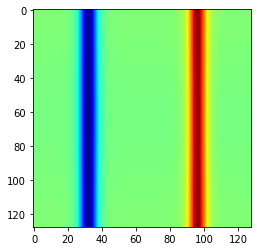

In [27]:
# plot the solution at the final timestamp

plt.imshow(np.real(np.fft.ifft2(omegaT_tilde)), cmap='jet')

It is unclear why, but the vorticity is abscent. I didn't manage to find any error from my part, especially considering all the tests are passed.